In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
from tqdm.notebook import tqdm

# Suppress warnings 
import warnings
import os

tqdm.pandas()
warnings.filterwarnings('ignore')

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}
df = pd.read_csv('/opt/ml/input/data/train_dataset/train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 5.09 s, sys: 604 ms, total: 5.7 s
Wall time: 5.7 s


- userID 사용자의 고유번호(총 7,442명의 고유 사용자, train/test셋 90/10의 비율)

- assessmentItemID 문항의 고유번호 (총 9,454개의 고유 문항)

- testId 시험지의 고유번호 (총 1,537개의 고유한 시험지)

- answerCode 해당 문항을 맞췄는지 여부 (0 : 틀린 것, 1 : 맞춘 것)

- Timestamp 사용자가 해당문항을 풀기 시작한 시점의 데이터

- KnowledgeTag 문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할, 태그 자체의 정보는 비식별화 되어있지만, 문항을 군집화하는데 사용할 수 있습니다. (912개의 고유 태그 존재)

## answerCode 데이터 분포 플롯
- 전체 데이터의 정답 여부 분포
- 틀리는 것 보다는 맞추는 게 2배 정도!

1    1483205
0     783381
Name: answerCode, dtype: int64

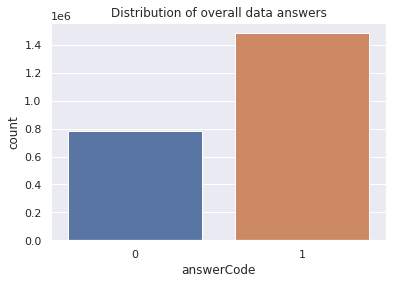

In [3]:
sns.countplot(df.answerCode).set_title('Distribution of overall data answers');
df.answerCode.value_counts()

## 유저별 Last question 데이터 분포 플롯
- 사용자 별 마지막 문제의 정답 여부의 분포(train)

0    3488
1    3210
Name: answerCode, dtype: int64

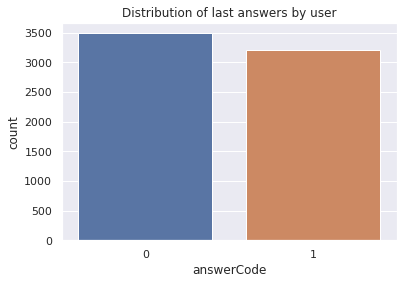

In [5]:
Last_Label = df.groupby('userID').apply(lambda subf: subf['answerCode'][subf['Timestamp'].idxmax()])
Last_Label = Last_Label.reset_index()
Last_Label.columns = ['userID', 'answerCode']

sns.countplot(Last_Label.answerCode).set_title('Distribution of last answers by user');
Last_Label.answerCode.value_counts()

- 사용자 별 마지막 문제의 정답 여부의 분포(test)

1    413
0    331
Name: answerCode, dtype: int64

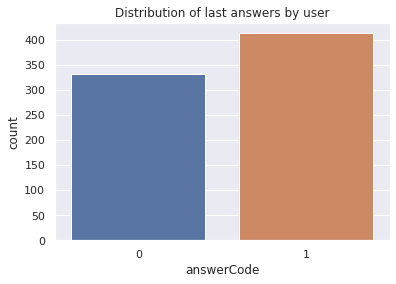

In [6]:
data_dir = '/opt/ml/input/data/train_dataset'
# LOAD TEST DATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=['Timestamp'])

test_df = test_df[test_df['answerCode']!=-1]

Last_Label = test_df.groupby('userID').apply(lambda subf: subf['answerCode'][subf['Timestamp'].idxmax()])
Last_Label = Last_Label.reset_index()
Last_Label.columns = ['userID', 'answerCode']

sns.countplot(Last_Label.answerCode).set_title('Distribution of last answers by user');
Last_Label.answerCode.value_counts()

## 유저별 First Label 데이터 분포 플롯

1    4806
0    1892
Name: answerCode, dtype: int64

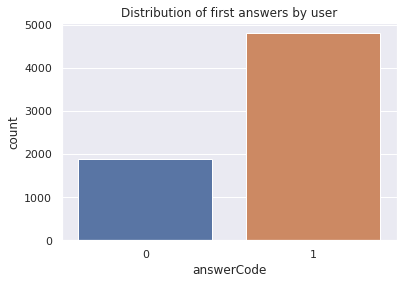

In [8]:
First_Label = df.groupby('userID').apply(lambda subf: subf['answerCode'][subf['Timestamp'].idxmin()])
First_Label = First_Label.reset_index()
First_Label.columns = ['userID', 'answerCode']

sns.countplot(First_Label.answerCode).set_title('Distribution of first answers by user');
First_Label.answerCode.value_counts()

## 유저별 일자별(Daily) First Label 데이터 분포 플롯

1    214996
0     74406
Name: answerCode, dtype: int64

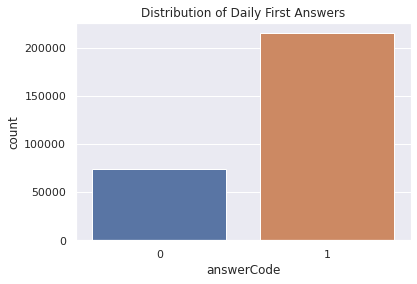

In [12]:
first_1d = df.groupby(['userID', pd.Grouper(freq='1D',key='Timestamp')]).progress_apply(lambda subf: subf['answerCode'][subf['Timestamp'].idxmin()])
first_1d = first_1d.reset_index()
first_1d.columns = ['userID', 'Timestamp', 'answerCode']
sns.countplot(first_1d.answerCode).set_title('Distribution of Daily First Answers');
first_1d.answerCode.value_counts()

## 유저별 일자별(Daily) Last Label 데이터 분포 플롯

1    159434
0    129968
Name: answerCode, dtype: int64

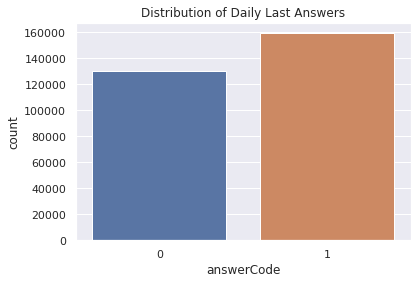

In [13]:
last_1d = df.groupby(['userID', pd.Grouper(freq='1D',key='Timestamp')]).progress_apply(lambda subf: subf['answerCode'][subf['Timestamp'].idxmax()])
last_1d = last_1d.reset_index()
last_1d.columns = ['userID', 'Timestamp', 'answerCode']
sns.countplot(last_1d.answerCode).set_title('Distribution of Daily Last Answers');
last_1d.answerCode.value_counts()

## 월별 데이터 분포

In [14]:
last_1M = df.groupby([pd.Grouper(freq='1M',key='Timestamp')])["answerCode"].agg(["mean", "sum", "count"])
last_1M[1:]

,mean,sum,count
Timestamp,,,
2020-01-31,0.712199,26627.0,37387
2020-02-29,0.687222,54619.0,79478
2020-03-31,0.682643,119109.0,174482
2020-04-30,0.649545,114939.0,176953
2020-05-31,0.643317,118252.0,183816
2020-06-30,0.651967,148310.0,227481
2020-07-31,0.665650,180123.0,270597
2020-08-31,0.657599,207877.0,316115
2020-09-30,0.668872,226925.0,339265


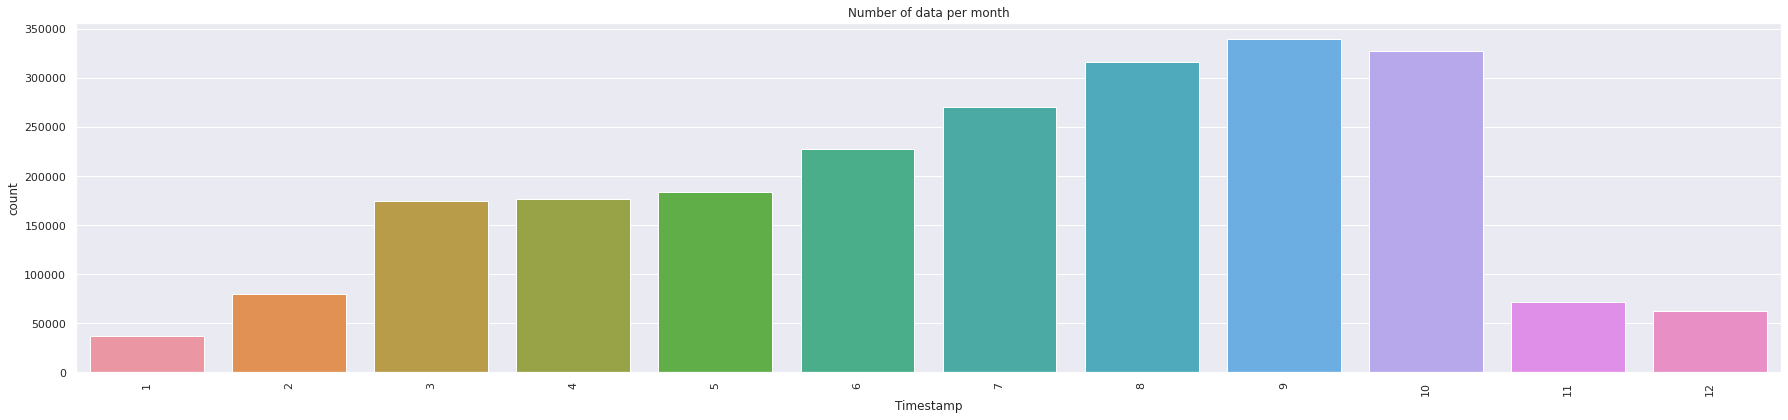

In [15]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month , y=last_1M[1:]['count']) #2019년 12월 제외
plt.xticks(rotation=90)
plt.title('Number of data per month')
plt.tight_layout()

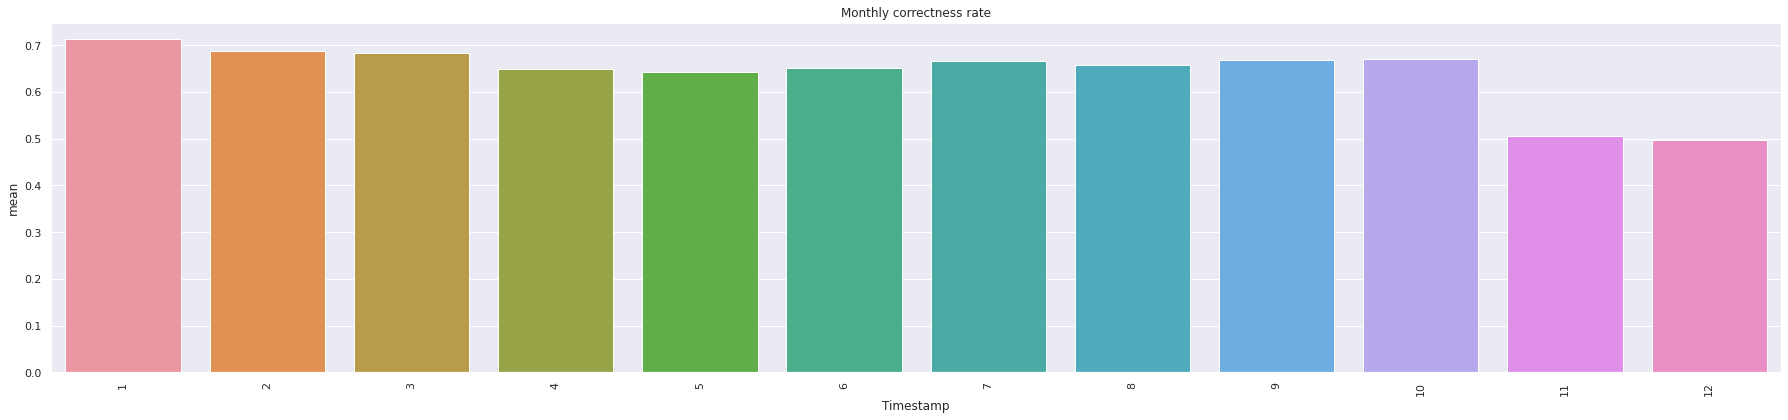

In [16]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month , y=last_1M[1:]['mean']) #2019년 12월 제외
plt.xticks(rotation=90)
plt.title('Monthly correctness rate')
plt.tight_layout()

## 시간대별 데이터 분포

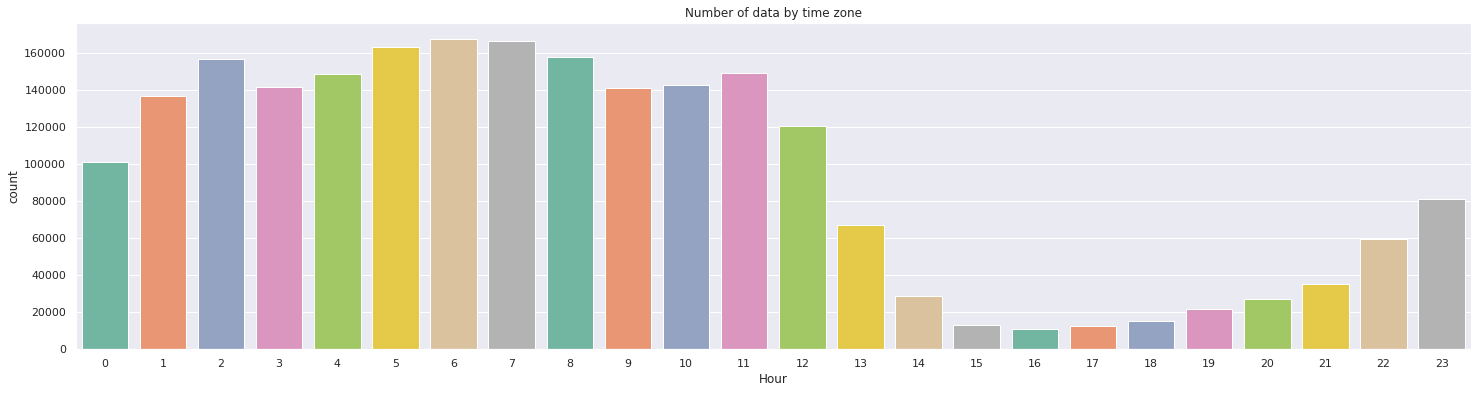

In [17]:
df['Hour'] = df['Timestamp'].dt.hour 
Hour_ans_rate = df.groupby(["Hour"])["answerCode"].agg(["mean", "count"]).reset_index()

#시간대별 데이터 수 : 너네.. 왜 새벽에 공부해...?
plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="count", data=Hour_ans_rate, palette='Set2')
plt.title('Number of data by time zone')
plt.show()

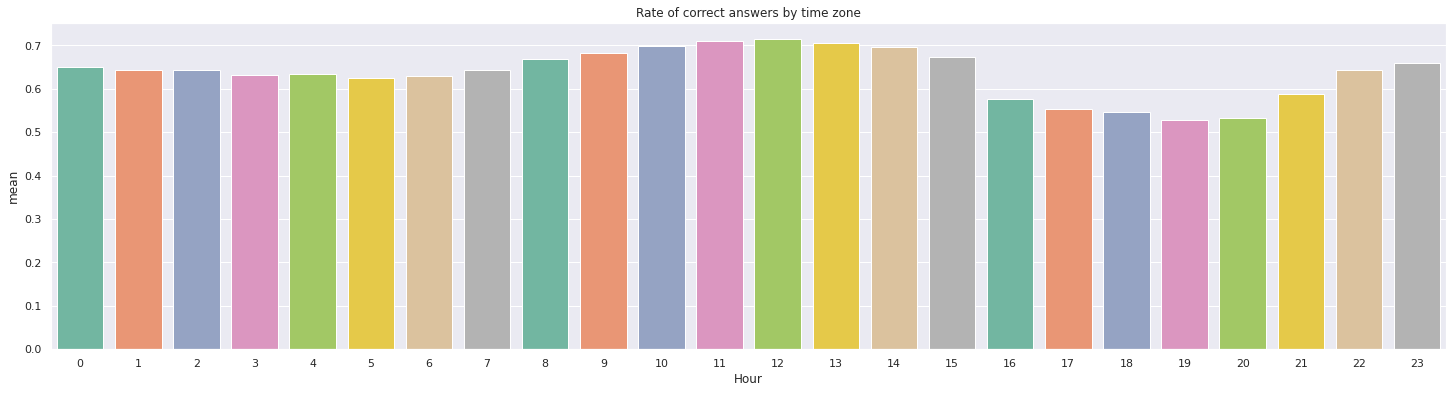

In [18]:
#시간대별 정답률
plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="mean", data=Hour_ans_rate, palette='Set2')
plt.title('Rate of correct answers by time zone')
plt.show()

## Feature Engineering 

- 문제 푼 시간이 10분이 넘어가는 data
- 마지막 문제를 풀고 바로 이어서 문제를 풀지 않은 경우

In [19]:
# 유저별 날짜별로 정렬
df.sort_values(by=["userID", "Timestamp"], inplace=True)

diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

max_time = 600
elapsed = diff['Timestamp'].progress_apply(lambda x: x.total_seconds() if max_time > x.total_seconds() else None)

elapsed.isnull().sum() 

378089

## **문제 푼 시간**

- 대략 elapsed 값이 10을 넘어가면 다음 날로 넘어간 것을 확인할 수 있음
- elapsed >= 10 인 값들의 elapsed 값을 해당 user의 해당 test지에서 평균 elapsed 값으로 교체

In [26]:
def change_elapsed(data):
    return data["elapsed"] if not data["is_elapsed_more_600"] else data["userID_testId_elapsed_mean"]
    
def change_log_elapsed(data):
    return data["log_elapsed"] if not data["is_elapsed_more_10"] else data["userID_testId_log_elapsed_mean"]

def get_elapsed(df):
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    elapsed = diff['Timestamp'].apply(lambda x: x.total_seconds())
    elapsed_log = diff['Timestamp'].apply(lambda x: np.log1p(x.total_seconds()))
    
    df['elapsed'] = elapsed
    df['log_elapsed'] = elapsed_log
    
    ### 특정 기준치를 벗어나면 해당 user의 해당 test지에 대한 평균 elapsed time으로 교체
    df["is_elapsed_more_600"] = df["elapsed"].apply(lambda x : True if x > 600 else False)
    df["is_elapsed_more_10"] = df["log_elapsed"].apply(lambda x : True if x > 10 else False)
    
    group_userID_testId = df[~df["is_elapsed_more_600"]].groupby(["userID", "testId"])["elapsed"].agg(["mean"])
    group_userID_testId = group_userID_testId.reset_index()
    group_userID_testId.columns = ["userID", "testId", "userID_testId_elapsed_mean"]

    group_userID_testId_log = df[~df["is_elapsed_more_10"]].groupby(["userID", "testId"])["log_elapsed"].agg(["mean"])
    group_userID_testId_log = group_userID_testId_log.reset_index()
    group_userID_testId_log.columns = ["userID", "testId", "userID_testId_log_elapsed_mean"]

    df = pd.merge(df, group_userID_testId, on=["userID", "testId"], how="left")
    df = pd.merge(df, group_userID_testId_log, on=["userID", "testId"], how="left")

    df["elapsed"] = df.apply(change_elapsed, axis=1)
    df["log_elapsed"] = df.apply(change_log_elapsed, axis=1)
    
    df = df.drop(['is_elapsed_more_600', 'is_elapsed_more_10', 'userID_testId_elapsed_mean', 'userID_testId_log_elapsed_mean'], axis=1)
    df = df.fillna(0.0)
    
    return df

In [27]:
%%time
df = get_elapsed(df)

CPU times: user 2min 14s, sys: 2.87 s, total: 2min 16s
Wall time: 2min 17s


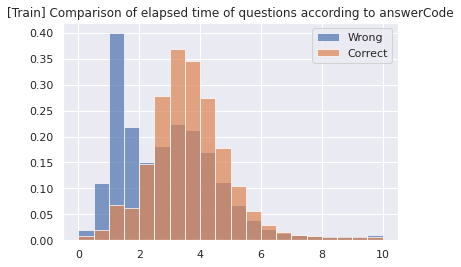

In [28]:
fig, ax = plt.subplots()
ax.set_title('[Train] Comparison of elapsed time of questions according to answerCode')
df[df['answerCode'] == 0]['log_elapsed'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Wrong')
df[df['answerCode'] == 1]['log_elapsed'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Correct')
ax.legend()

## question_num(문제지 안 문제 번호)

In [21]:
df.sort_values(by=['userID', 'Timestamp'], inplace=True)

df["question_num"] = df["assessmentItemID"].apply(lambda x: x[-3:])
df.question_num.value_counts()

001    371755
003    371640
002    370972
004    369705
005    360607
006    197772
007    127121
008     67150
009     18417
010      5342
011      3352
012      2484
013       269
Name: question_num, dtype: int64

## **문제의 난이도**
- 문제의 정답률, 문제가 속한 시험지의 정답률, 문제가 속한 대분류별 정답률, 문제 태그의 정답률에 가중치를 줘서 문제의 난이도 feature 생성

In [29]:
def get_question_class(df):
    df["questionClass"] = df["assessmentItemID"].apply(lambda x: x[2])
    return df

def get_accuracy(df):
    if not ('questionClass' in df.keys()):
        df = get_question_class(df)
    if not ('item_order_in_test' in df.keys()):
        df['item_order_in_test'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
    accuracy_by_test_id = df.groupby('testId')['answerCode'].mean()
    accuracy_by_question_id = df.groupby('assessmentItemID')['answerCode'].mean()
    accuracy_by_class_id = df.groupby('questionClass')['answerCode'].mean()
    accuracy_by_tag = df.groupby('KnowledgeTag')['answerCode'].mean()
    accuracy_by_order = df.groupby('item_order_in_test')['answerCode'].mean()
    
    df['accuracy_avg_by_test_id'] = df['testId'].map(accuracy_by_test_id)
    df['accuracy_avg_by_question_id'] = df['assessmentItemID'].map(accuracy_by_question_id)
    df['accuracy_avg_by_class_id'] = df['questionClass'].map(accuracy_by_class_id)
    df['accuracy_avg_by_tag'] = df['KnowledgeTag'].map(accuracy_by_tag)
    df['accuracy_avg_by_order'] = df['item_order_in_test'].map(accuracy_by_order)
    df = df.fillna(0.0)
    
    return df

In [30]:
%%time
df = get_accuracy(df)

CPU times: user 3.65 s, sys: 308 ms, total: 3.96 s
Wall time: 3.96 s


In [31]:
# LDA를 이용하여 유저가 느낀 문제의 난이도 피처를 만들어보자
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def get_accuracy_lda(df):
    lda = LDA(n_components=1)
    X = df[['accuracy_avg_by_test_id',
       'accuracy_avg_by_question_id', 'accuracy_avg_by_class_id',
       'accuracy_avg_by_tag', 'accuracy_avg_by_order']]
    y = df[['answerCode']]
    df['accuracy_lda'] = lda.fit_transform(X, np.ravel(y))
    return df

def get_elapsed_lda(df):
    lda = LDA(n_components=1)
    X = df[['elapsed', 'relative_elapsed_0', 'relative_elapsed_1', 'log_elapsed', 'relative_log_elapsed_0', 'relative_log_elapsed_1']]
    y = df[['answerCode']]
    df['elapsed_lda'] = lda.fit_transform(X, np.ravel(y))
    return df

In [32]:
%%time
df = get_accuracy_lda(df)

CPU times: user 2.65 s, sys: 556 ms, total: 3.21 s
Wall time: 2.6 s


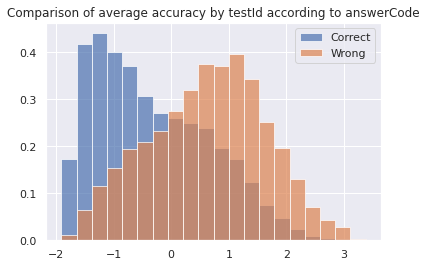

In [33]:
fig, ax = plt.subplots()
ax.set_title('Comparison of average accuracy by testId according to answerCode')
df[df['answerCode'] == 1]['accuracy_lda'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Correct')
df[df['answerCode'] == 0]['accuracy_lda'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Wrong')
ax.legend()

## 각 User는 몇개의 TestId를 풀었는지

In [36]:
stu_groupby = df.groupby('userID')
stu_groupby['testId'].unique().apply(len).describe()

count    6698.000000
mean       54.518364
std        50.774874
min         2.000000
25%        13.000000
50%        38.000000
75%        83.000000
max       301.000000
Name: testId, dtype: float64

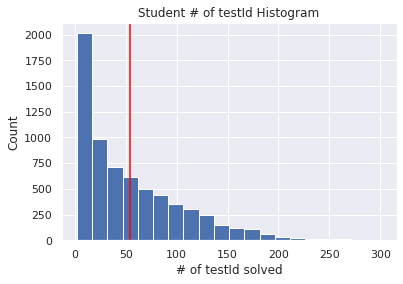

In [37]:
fig, ax = plt.subplots()
stu_groupby['testId'].unique().apply(len).hist(bins=20, ax=ax)
ax.set_title('Student # of testId Histogram')
ax.set_xlabel('# of testId solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['testId'].unique().apply(len).mean(), color='red')
ax.grid(b=True)

## User가 TestId를 접한 횟수와 점수와의 상관관계 파악

Text(0.5, 1.0, '# Num of TestId Exposed - Answer Rate')

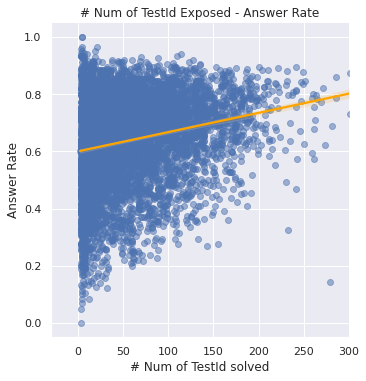

In [43]:
def percentile(s):
    return np.sum(s) / len(s)

user_test_groupby = df.groupby(['userID','testId']).agg({
    'answerCode': percentile,
    'assessmentItemID':'count'
})

user_test_num_groupby = user_test_groupby.groupby('userID').agg({
    'answerCode': percentile,
    'assessmentItemID' : 'count'
})

g = sns.lmplot(data=user_test_num_groupby, x="assessmentItemID", y="answerCode",
              scatter_kws={'alpha':0.5}, line_kws={"color": "orange"})
g.set_xlabels('# Num of TestId solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 300))
ax = plt.gca()
ax.set_title('# Num of TestId Exposed - Answer Rate')

## KnowledgeTag별 정답률은 차이가 있는지

In [44]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


Text(0.5, 1.0, '# Num of Tag - Answer Rate')

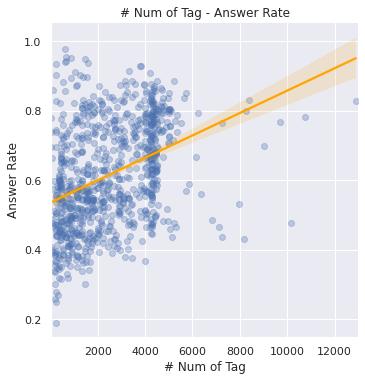

In [45]:
g = sns.lmplot(data=tag_groupby, x='userID', y='answerCode',
              scatter_kws={'alpha':0.3}, line_kws={"color": "orange"})
g.set_xlabels('# Num of Tag')
g.set_ylabels('Answer Rate')
g.set(xlim=(30, 13000))
ax = plt.gca()
ax.set_title('# Num of Tag - Answer Rate')